In [1]:
# Import libaries and illustris library
import numpy as np
import illustris_python as il
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import gridspec
%matplotlib inline
import random
import subroutines.tree_functions as tf
hubble = 0.704
import sys
sys.path.append("/Users/alex/Documents/Research/Astro/illustrisAPI")
import iApi as iapi
iapi.headers['api-key']='4bf1a1e26a9a0777777dd7fa074e2e1f'

In [123]:
plt.style.use('default')
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['font.size']=15
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['ytick.major.size'] = 7

yor__cmap = mpl.cm.get_cmap('YlOrRd');
vir__cmap = mpl.cm.get_cmap('viridis');
greys__cmap = mpl.cm.get_cmap('Greys');
tab_cmap = mpl.cm.get_cmap('tab20b');

%reload_ext autoreload
%autoreload 2

In [3]:
def maskEllips(whichSnap):
    return (galData[whichSnap][:,14]<0.5);
def maskMass(whichSnap, mass_low, mass_high=50000):
    return ( (mass_high>galData[whichSnap][:,2]) & (galData[whichSnap][:,2]>mass_low) );
def maskMass_data(data, mass_low, mass_high=50000):
    return ( (mass_high>data) & (data>mass_low) );
def maskWeb(whichSnap, webValue):
    return (webData[whichSnap][:,17]==webValue);
def maskWeb_ellip(whichSnap, webValue):
    return (webData_ellip[whichSnap][:,17]==webValue);
def mass_color_map(mass_data, steps, max_mass=-1, min_mass=-1):
    output = np.zeros((mass_data.shape[0]))
    if max_mass == -1:
        max_mass=max(mass_data[:])
    if min_mass == -1:
        min_mass=min(mass_data[:])

        step_size= (abs(max_mass)+abs(min_mass))/(steps-1)
        bins =  np.arange(min_mass, max_mass+step_size, step_size)
        for j in range(0,bins.size-1):
            for i in range (0, mass_data.shape[0]):
                if (mass_data[i]>bins[j]) & (mass_data[i]<bins[j+1]):
                    output[i] = 0.1+(j/steps)
    return output

In [4]:
#load data
snaps=[135,116,103,85]
galData = []
webData = []
for i in snaps:
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    galData.append(np.genfromtxt('../../Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

    # 0:HaloNumber, 1:SubhaloNumber, 2-4:SubhaloPosition x,y,z, 5: Index of nearest critical point, 6: absolute distance to crit., 7-9: nearest critical point coordinates, 
    # 10: Index of nearest filament, 11:absolute distance to filament, 12-14: nearest filament coordinates, 15: cos(theta) 16:sin(theta) 17:cluster(1) fil(0) nothing(-1)
    # 17: cluster=1, filament=0, none=-1
    webData.append(np.genfromtxt('../../Data/WebData/galaxy_web_data.'+str(i)+'.txt'))

galData_ellip = []; galData_disk = [];
webData_ellip = []; webData_disk = [];
for i in range (0,4):
    galData_ellip.append(galData[i][maskEllips(i)])
    webData_ellip.append(webData[i][maskEllips(i)])
    galData_disk.append(galData[i][~maskEllips(i)])
    webData_disk.append(webData[i][~maskEllips(i)])
#load all galaxy data
allgalData = []
for i in range (135,84,-1):
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    allgalData.append(np.genfromtxt('../../Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

allgalData_ellip = []; allgalData_disk = [];
for i in range(0,51):
    allgalData_ellip.append(allgalData[i][allgalData[i][:,14]<0.5]);
    allgalData_disk.append(allgalData[i][allgalData[i][:,14]>0.5]);

In [5]:
noMaj_nsnap = np.genfromtxt('../../Data/noMajors_nsub.txt').astype(int)
subhalo_numbers = np.genfromtxt('subhalo_numbers.txt').astype(int)

In [7]:
def find_gal_in_rad(pos_data, mass_data, vel_data, index_of_gal, rad = 1000, mass=0.1):
    gal_position = pos_data[index_of_gal,:]
    pos_mask = (((gal_position[0]+rad)>pos_data[:,0]) & (pos_data[:,0]>(gal_position[0]-rad)) & 
                ((gal_position[1]+rad)>pos_data[:,1]) & (pos_data[:,1]>(gal_position[1]-rad)) &
                ((gal_position[2]+rad)>pos_data[:,2]) & (pos_data[:,2]>(gal_position[2]-rad)) &
                ((gal_position[2]) != pos_data[:,2])
               )
    mass_mask = mass_data[:]>mass
    return pos_data[pos_mask & mass_mask]-gal_position, mass_data[pos_mask & mass_mask], vel_data[pos_mask & mass_mask], gal_position, mass_data[index_of_gal]

In [9]:
pathToDir='/Users/alex/Documents/Research/Astro/git_rep/Data/FlybyData/'
positions = []
masses = []
velocities= []
subhalo_parent= []
half_mass_rad= []
for snapNum in np.arange(135,84,-1):
    positions.append(iapi.getSubhaloField('SubhaloPos',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloPos.'+str(snapNum)))
    masses.append(iapi.getSubhaloField('SubhaloMassType',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloMassType.'+str(snapNum))[:,1])
    velocities.append(iapi.getSubhaloField('SubhaloVel',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloVel.'+str(snapNum)))
    half_mass_rad.append(iapi.getSubhaloField('SubhaloHalfmassRad',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloHalfmassRad.'+str(snapNum)))

In [34]:
def find_gal_in_rad(pos_data, mass_data, vel_data, rad_data, index_of_gal, rad = 1000, mass=0.1):
    gal_position = pos_data[index_of_gal,:]
    pos_mask = (((gal_position[0]+rad)>pos_data[:,0]) & (pos_data[:,0]>(gal_position[0]-rad)) & 
                ((gal_position[1]+rad)>pos_data[:,1]) & (pos_data[:,1]>(gal_position[1]-rad)) &
                ((gal_position[2]+rad)>pos_data[:,2]) & (pos_data[:,2]>(gal_position[2]-rad)) & 
                 (gal_position[0]!=pos_data[:,0]) & 
                 (gal_position[1]!=pos_data[:,1]) & 
                 (gal_position[2]!=pos_data[:,2])
               )
    mass_mask = mass_data[:]>mass
    return pos_data[pos_mask & mass_mask]-gal_position, mass_data[pos_mask & mass_mask], vel_data[pos_mask & mass_mask], gal_position, mass_data[index_of_gal], rad_data[pos_mask & mass_mask]

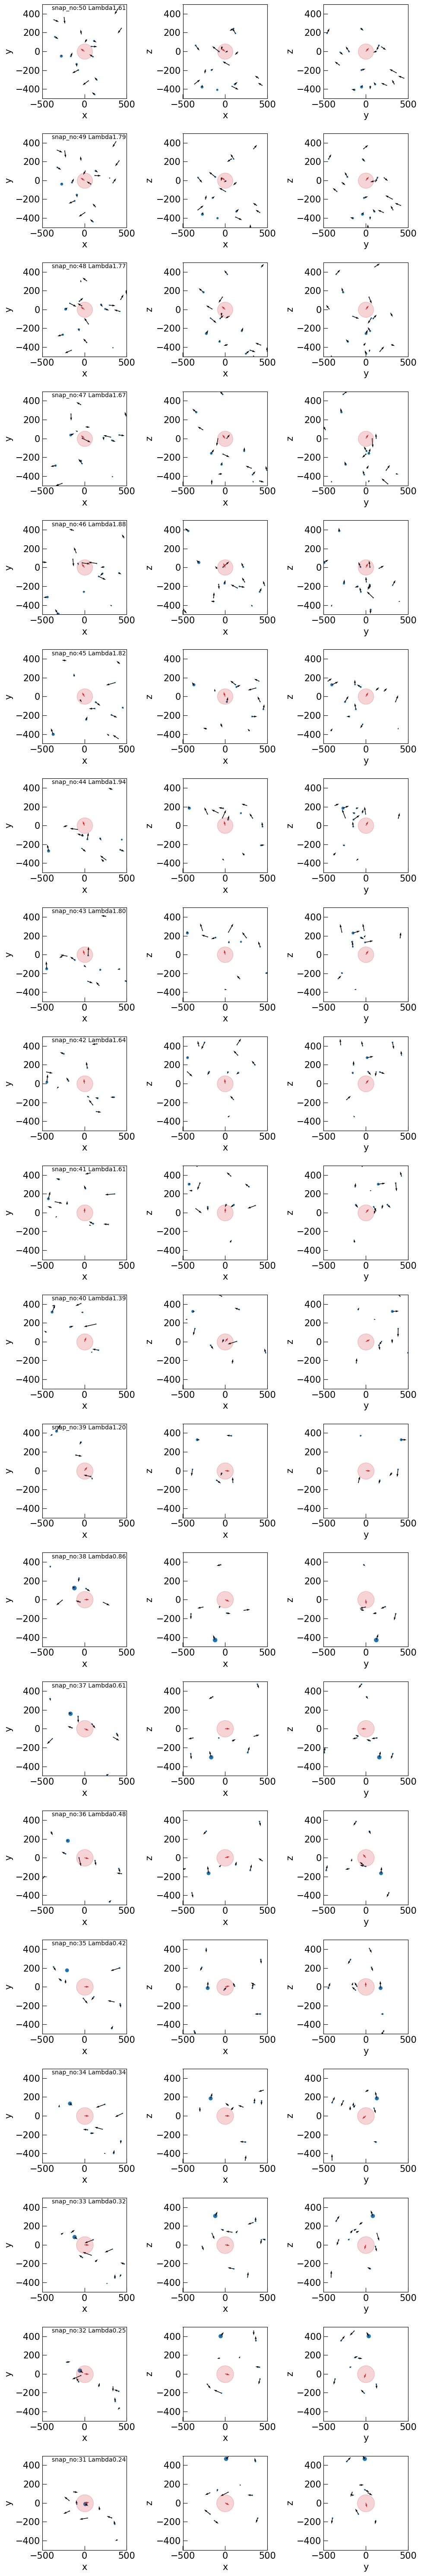

In [36]:
galaxy_number = 4
z_back_start = 0 # counts snapshots from z=1 forward in time
z_back_end = 20
size = 500
fig = plt.figure(figsize=(10, 3*(z_back_end-z_back_start))); gs=gridspec.GridSpec(z_back_end-z_back_start,3); count =0;

for i in  np.arange(50-z_back_start,50-z_back_end,-1):
    nearby_gal = find_gal_in_rad(positions[i]/hubble, masses[i]/hubble,velocities[i], half_mass_rad[i]/hubble, subhalo_numbers[galaxy_number][i], size, 0.5)
    gal_ang_mom = allgalData[i][np.argwhere(allgalData[i][:,1]==subhalo_numbers[galaxy_number][i])[0][0],11:14]
    gal_vel = velocities[i][subhalo_numbers[galaxy_number][i]]
    gal_lambda = allgalData[i][np.argwhere(allgalData[i][:,1]==subhalo_numbers[galaxy_number][i])[0][0],16]
    gal_half_mass_rad = (half_mass_rad[i]/hubble)[subhalo_numbers[galaxy_number][i]]
    gal_mass = masses[i][subhalo_numbers[galaxy_number][i]]
    nearby_pos = nearby_gal[0]
    nearby_mass = nearby_gal[1]
    nearby_vel = nearby_gal[2]-gal_vel
    nearby_rad = nearby_gal[5]
    #color_map = mass_color_map(nearby_mass,10) 

    ax1 = plt.subplot(gs[count,0]); ax2 = plt.subplot(gs[count,1]); ax3 = plt.subplot(gs[count,2]); count=count+1
    ax1.scatter(nearby_pos[:,0], nearby_pos[:,1], s=nearby_mass)#c= vir__cmap(color_map))
    ax1.quiver(nearby_pos[:,0], nearby_pos[:,1], nearby_vel[:,0], nearby_vel[:,1])
    ax1.set_xlabel('x'),ax1.set_ylabel('y')

    ax1.scatter(0,0 ,c='C3', s=gal_mass, alpha=0.2); 
    ax1.set_xlim([-size,size]); ax1.set_ylim([-size,size])
    ax1.quiver(0,0,gal_ang_mom[0],gal_ang_mom[1], facecolor='C3')
    
    ax2.scatter(nearby_pos[:,0], nearby_pos[:,2], s=nearby_mass)#c= vir__cmap(color_map))
    ax2.quiver(nearby_pos[:,0], nearby_pos[:,2], nearby_vel[:,0], nearby_vel[:,2])

    ax2.scatter(0,0 ,c='C3', s=gal_mass, alpha=0.2);  ax2.set_xlim([-size,size]); ax2.set_ylim([-size,size])
    ax2.quiver(0,0,gal_ang_mom[0],gal_ang_mom[2], facecolor='C3')
    ax2.set_xlabel('x'),ax2.set_ylabel('z')
    
    ax3.scatter(nearby_pos[:,1], nearby_pos[:,2], s=nearby_mass)#c= vir__cmap(color_map))
    ax3.quiver(nearby_pos[:,1], nearby_pos[:,2], nearby_vel[:,1], nearby_vel[:,2])
    ax3.scatter(0,0 ,c='C3', s=gal_mass, alpha=0.2);  ax3.set_xlim([-size,size]); ax3.set_ylim([-size,size])
    ax3.quiver(0,0,gal_ang_mom[1],gal_ang_mom[2], facecolor='C3')
    ax3.set_xlabel('y'),ax3.set_ylabel('z')
    
    ax1.text(490,440, 'snap_no:'+str(i)+' Lambda'+str('%.2f'%(gal_lambda)) ,fontsize=10, ha='right');
    #print(nearby_mass)
plt.tight_layout()
plt.show()
#fig.savefig('../../Plots/NoMajs_gal_'+str(galaxy_number)+'.pdf', format='pdf')

In [41]:
def flybys_param(pos_data, mass_data, vel_data, index_of_gal, rad, mass_low=0.1, mass_high=30000):
    gal_position = pos_data[index_of_gal,:]
    gal_vel      = vel_data[index_of_gal,:]
    mass_mask = (mass_high>mass_data[:]) & (mass_data[:]>mass_low)

    pos_mask = (((gal_position[0]+rad)>pos_data[:,0]) & (pos_data[:,0]>(gal_position[0]-rad)) & 
                ((gal_position[1]+rad)>pos_data[:,1]) & (pos_data[:,1]>(gal_position[1]-rad)) &
                ((gal_position[2]+rad)>pos_data[:,2]) & (pos_data[:,2]>(gal_position[2]-rad)) & 
                 (gal_position[0]!=pos_data[:,0]) & 
                 (gal_position[1]!=pos_data[:,1]) & 
                 (gal_position[2]!=pos_data[:,2])
               )
    
    pos_data_box  = pos_data[pos_mask & mass_mask]
    mass_data_box = mass_data[pos_mask & mass_mask]
    #vel_data_box  = vel_data[pos_mask & mass_mask]
    
    #vel_abs = np.sqrt((vel_data_box[:,0]-gal_vel[0])**2 + (vel_data_box[:,1]-gal_vel[1])**2 + (vel_data_box[:,2]-gal_vel[2])**2)
    
    distance = np.sqrt((pos_data_box[:,0]-gal_position[0])**2 + (pos_data_box[:,1]-gal_position[1])**2 + (pos_data_box[:,2]-gal_position[2])**2)

    radial_vec = (pos_data_box-gal_position)/distance[:, np.newaxis]
    delta_v = radial_vec * (mass_data_box/((distance)**2))[:, np.newaxis]
    
    return delta_v

def flyby_param_plot(galaxy_number):
    delta_v = np.zeros((51,3))
    
    for i in  np.arange(0,51):
        gal_half_mass_rad = (half_mass_rad[i]/hubble)[subhalo_numbers[galaxy_number][i]]
        gal_mass = masses[i][subhalo_numbers[galaxy_number][i]]
        flyby_param = flybys_param(positions[i]/hubble, masses[i]/hubble, velocities[i], subhalo_numbers[galaxy_number][i], gal_half_mass_rad*2, 0.1)
        gal_lambda = allgalData[i][np.argwhere(allgalData[i][:,1]==subhalo_numbers[galaxy_number][i])[0][0],16]
        delta_v[i, 0] = i
        if flyby_param.size != 0:
            delta_v[i, 1] = np.linalg.norm(sum(flyby_param)/gal_mass)
        else:
            delta_v[i, 1] = 0
        delta_v[i, 2] = gal_lambda
    return delta_v

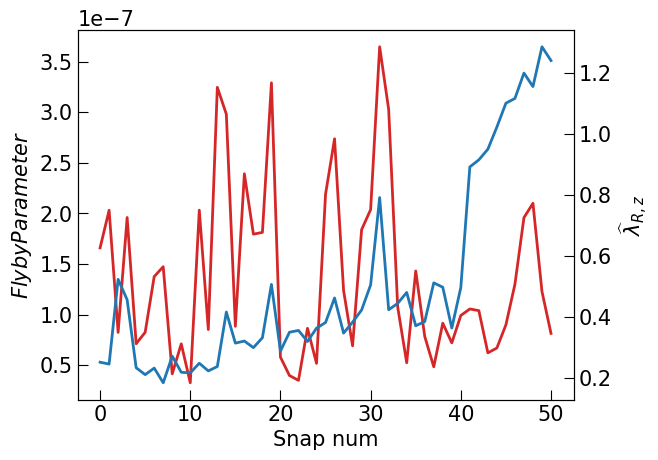

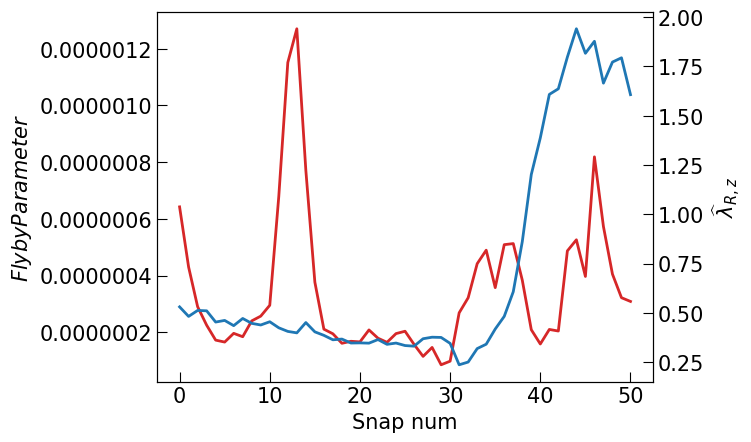

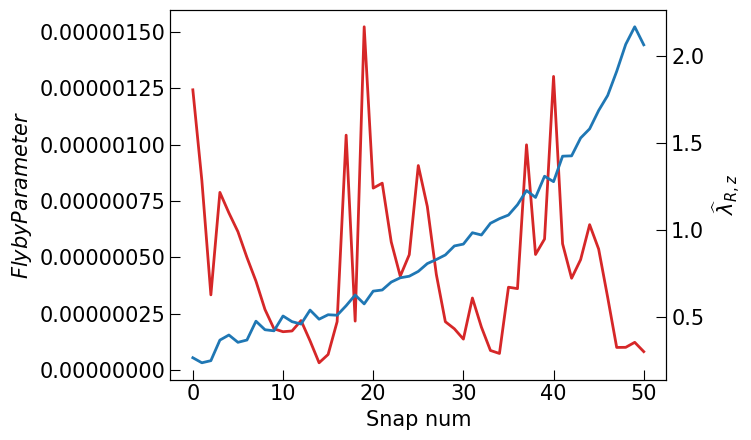

In [790]:
galaxy_numbers = np.array([0,4,6])
for j in range(0,galaxy_numbers.size):
    galaxy_number = galaxy_numbers[j]

    delta_v = flyby_param_plot(galaxy_number)
    ax1 = plt.subplot()
    ax1.plot(delta_v[0:51,0], delta_v[0:51,1], c='C3')
    ax1.set_ylabel('$Flyby Parameter$'); ax1.set_xlabel('Snap num')
    ax2 = ax1.twinx()
    ax2.plot(delta_v[:,0], delta_v[:,2])
    ax2.set_ylabel(r'$\widehat{\lambda}_{R, z}$')
    plt.show()

In [115]:
from numba import jit

In [201]:
def flyby_quant(output, pos_data, mass_data, index_of_gal, rad, mass_brackets, rad_brackets, mass_low=0.1, mass_high=30000):
    gal_position = pos_data[index_of_gal,:]
    gal_mass = mass_data[index_of_gal] 
    mass_mask = (mass_high>mass_data[:]) & (mass_data[:]>mass_low)
    mass_data = mass_data[mass_mask]
    pos_data = pos_data[mass_mask]
    pos_mask = (((gal_position[0]+rad)>pos_data[:,0]) & (pos_data[:,0]>(gal_position[0]-rad)) & 
                ((gal_position[1]+rad)>pos_data[:,1]) & (pos_data[:,1]>(gal_position[1]-rad)) &
                ((gal_position[2]+rad)>pos_data[:,2]) & (pos_data[:,2]>(gal_position[2]-rad)) & 
                 (gal_position[0]!=pos_data[:,0]) & 
                 (gal_position[1]!=pos_data[:,1]) & 
                 (gal_position[2]!=pos_data[:,2])
               )
    
    pos_data_box  = pos_data[pos_mask]
    mass_data_box = mass_data[pos_mask]
    
    flyby_distances(pos_data_box, mass_data_box, gal_position, mass_brackets,rad, output[0,:])
    flyby_tot_mass(pos_data_box, mass_data_box, gal_position, rad_brackets, output[1,:])
    
    distance = np.sqrt((pos_data_box[:,0]-gal_position[0])**2 + (pos_data_box[:,1]-gal_position[1])**2 + (pos_data_box[:,2]-gal_position[2])**2)
    flyby_mom_grav(pos_data_box, mass_data_box, distance, gal_mass, gal_position, output[2:4,:])

def flyby_distances(pos_data_box, mass_data_box, gal_position, mass_brackets, rad,output):
    for k in range(0, len(mass_brackets)):
        mass_mask =  (mass_data_box[:]>mass_brackets[k])
        pos_data_dist = pos_data_box[mass_mask]
        dist = np.sqrt((pos_data_dist[:,0]-gal_position[0])**2 + (pos_data_dist[:,1]-gal_position[1])**2 + (pos_data_dist[:,2]-gal_position[2])**2)
        if dist.size != 0:
            output[k] = dist.min()
        else:
            output[k] = np.sqrt(3*(rad**2))

def flyby_tot_mass(pos_data_box, mass_data_box, gal_position, rad_brackets, output):
    for k in range(0, len(rad_brackets)):
        rad_k = rad_brackets[k]
        rad_mask = (((gal_position[0]+rad_k)>pos_data_box[:,0]) & (pos_data_box[:,0]>(gal_position[0]-rad_k)) & 
                ((gal_position[1]+rad_k)>pos_data_box[:,1]) & (pos_data_box[:,1]>(gal_position[1]-rad_k)) &
                ((gal_position[2]+rad_k)>pos_data_box[:,2]) & (pos_data_box[:,2]>(gal_position[2]-rad_k)) & 
                 (gal_position[0]!=pos_data_box[:,0]) & 
                 (gal_position[1]!=pos_data_box[:,1]) & 
                 (gal_position[2]!=pos_data_box[:,2])
               )
        mass_data_rad = mass_data_box[rad_mask]
        if mass_data_rad.size != 0:
            output[k] = mass_data_rad.sum()
        else:
            output[k] = 0
            
def flyby_mom_grav(pos_data_box, mass_data_box, distance, gal_mass,gal_position, output):
    
    radial_vec = (pos_data_box-gal_position)/distance[:, np.newaxis]
    dist_2 = (distance)**2
    dist_3 = (distance)**3
    dist_4 = dist_2**2
    output[0,0] = max( (mass_data_box/(dist_2 *gal_mass))[:, np.newaxis])
    output[0,1] = max( (mass_data_box/(dist_3 *gal_mass))[:, np.newaxis])
    output[0,2] = max( (mass_data_box/(dist_4 *gal_mass))[:, np.newaxis])
    
    grav_mom_2 = radial_vec * (mass_data_box/(dist_2))[:, np.newaxis]
    grav_mom_3 = radial_vec * (mass_data_box/(dist_3))[:, np.newaxis]
    grav_mom_4 = radial_vec * (mass_data_box/(dist_4))[:, np.newaxis]
    
    output[1,0] = np.linalg.norm(sum(grav_mom_2)/gal_mass)
    output[1,1] = np.linalg.norm(sum(grav_mom_3)/gal_mass)
    output[1,2] = np.linalg.norm(sum(grav_mom_4)/gal_mass)
    
    

In [254]:
def plot_flyby_quants(galaxy_numbers, rad, mass_brackets, rad_brackets):
    
    output_1 = np.zeros((51,4, max(len(mass_brackets),len(rad_brackets))))
    print(output_1.shape)
    output_2 = np.zeros((51,2))


    for j in range(0, galaxy_numbers.size):
        for i in  range(0,51):
            
            galaxy_number = galaxy_numbers[j]
            gal_lambda = allgalData[i][np.argwhere(allgalData[i][:,1]==subhalo_numbers[galaxy_number][i])[0][0],16]

            output_2[i,0] = i
            flyby_quant(output_1[i,:,:], positions[i]/hubble, masses[i]/hubble,subhalo_numbers[galaxy_number][i], rad, mass_brackets, rad_brackets)
            output_2[i,1] = gal_lambda
    return output_1, output_2

(51, 4, 9)


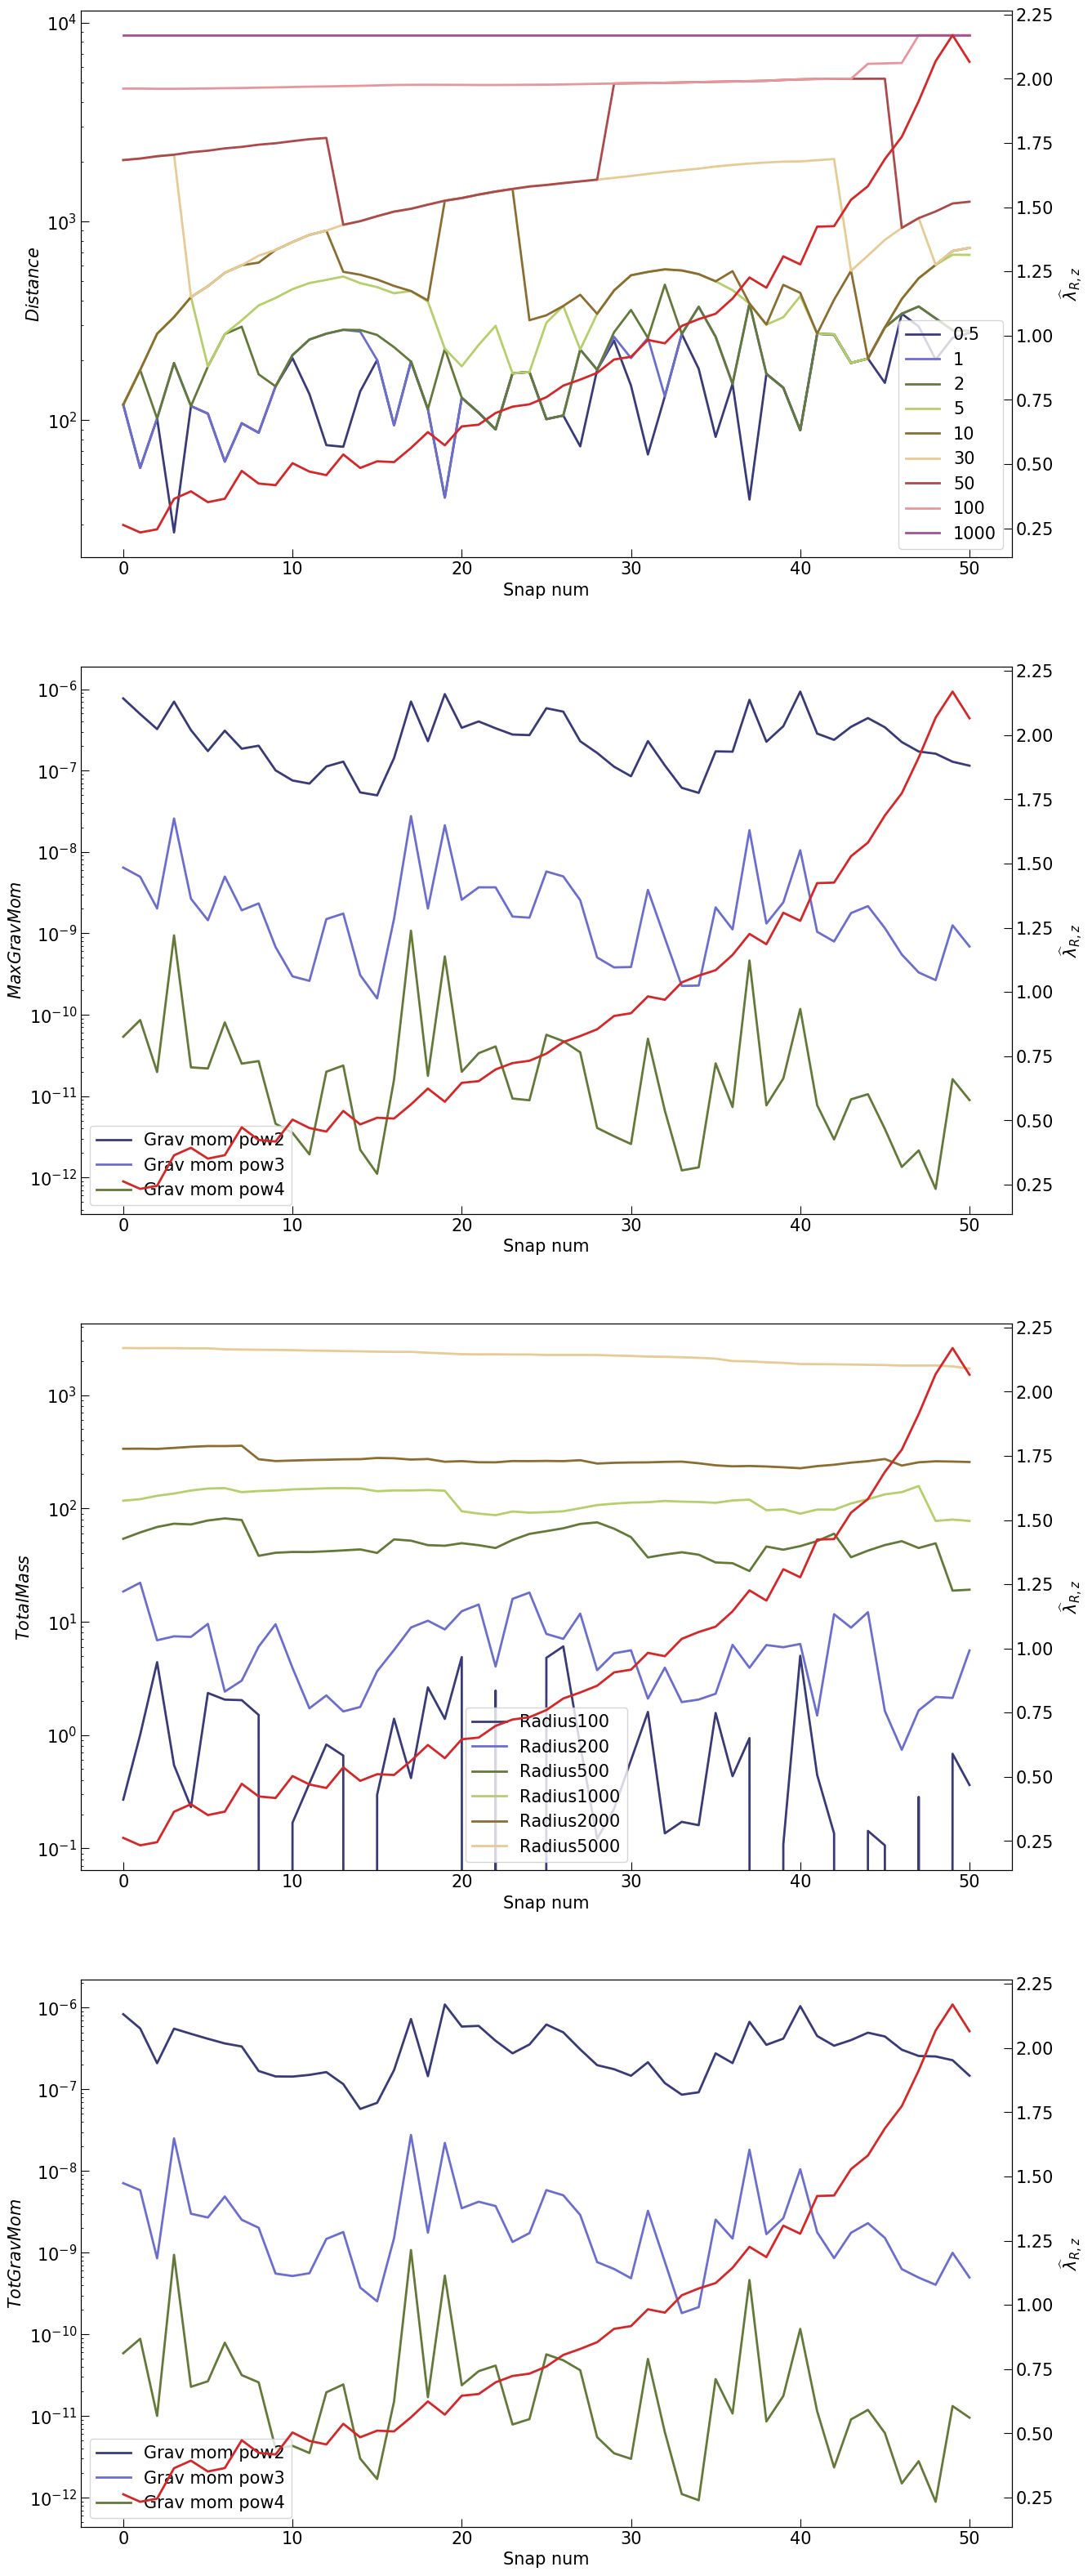

(51, 4, 9)


In [ ]:
galaxy_numbers = np.array([0,4,6])
mass_brackets = [0.5,1,2,5,10,30,50,100,1000]
rad_brackets = [100,200,500,1000,2000,5000]

fig = plt.figure(figsize=(50, 40));
gs=gridspec.GridSpec(4,galaxy_numbers.size);

for j in range(0, galaxy_numbers.size):
    output = plot_flyby_quants(galaxy_numbers, 5000, mass_brackets, rad_brackets)
    for k in range(0, len(mass_brackets)):
        ax1 = plt.subplot(gs[0,j]);
        ax1.plot(output[1][:,0], output[0][:,0,k], c=tab_cmap(k/len(lower_mass)), label=str(mass_brackets[k]))
        ax1.set_ylabel('$Distance$'); ax1.set_xlabel('Snap num')
        ax1.set_yscale('log'); ax1.legend(loc='best')
    ax2 = ax1.twinx()
    ax2.plot(output[1][:,0], output[1][:,1], c='C3')
    ax2.set_ylabel(r'$\widehat{\lambda}_{R, z}$')
    
    ax3 = plt.subplot(gs[1,j])
    for k in range(0,3):
        ax3.plot(output[1][:,0], output[0][:,2,k], c=tab_cmap(k/len(lower_mass)), label='Grav mom pow' +str(2+k))
        ax3.set_ylabel('$Max Grav Mom$'); ax3.set_xlabel('Snap num')
        ax3.set_yscale('log'); ax3.legend(loc='best')
    ax4 = ax3.twinx()
    ax4.plot(output[1][:,0], output[1][:,1], c='C3')
    ax4.set_ylabel(r'$\widehat{\lambda}_{R, z}$')
    
    for k in range(0, len(rad_brackets)):
        ax4 = plt.subplot(gs[2,j])
        ax4.plot(output[1][:,0], output[0][:,1,k], c=tab_cmap(k/len(lower_mass)), label='Radius'+str(rad_brackets[k]))
    ax4.set_ylabel('$Total Mass$'); ax4.set_xlabel('Snap num')
    ax4.set_yscale('log'); ax4.legend(loc='best')
    ax5 = ax4.twinx()
    ax5.plot(output[1][:,0], output[1][:,1],c='C3')
    ax5.set_ylabel(r'$\widehat{\lambda}_{R, z}$')
    
    ax6 = plt.subplot(gs[3,j])
    for k in range(0,3):
        ax6.plot(output[1][:,0],output[0][:,3,k], c=tab_cmap(k/len(lower_mass)), label='Grav mom pow' +str(2+k))
        ax6.set_ylabel('$Tot Grav Mom$'); ax6.set_xlabel('Snap num')
        ax6.set_yscale('log'); ax6.legend(loc='best')
    ax7 = ax6.twinx()
    ax7.plot(output[1][:,0], output[1][:,1], c='C3')
    ax7.set_ylabel(r'$\widehat{\lambda}_{R, z}$')
    plt.show()